In [1]:
import os
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_461"
os.environ["HADOOP_HOME"] = "C:/hadoop"

import sparknlp
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("SparkNLP")
         .config("spark.driver.memory", "8G")
         .config("spark.kryoserializer.buffer.max", "2000M")
         .config("spark.hadoop.native.io.enabled", "false")
         .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:6.2.2")
         .getOrCreate())
spark = sparknlp.start()
print("Spark NLP:", sparknlp.version())

Spark NLP: 6.2.2


In [6]:
df = (spark.read
      .option("header", "true")
      .option("multiLine", "true")
      .option("quote", '"')
      .option("escape", '"')
      .option("inferSchema", "true")
      .csv("scraped/.ipynb_checkpoints/reddit_posts.csv"))

df.printSchema()
df.show(5, truncate=False)


root
 |-- user: string (nullable = true)
 |-- date: date (nullable = true)
 |-- comment: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- type: string (nullable = true)

+------------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
from pyspark.sql.functions import col, length

df_clean = (df
    .filter(col("comment").isNotNull())
    .filter(length(col("comment")) > 20)
)

df_clean.select("user", "comment").show(5, truncate=False)


+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
from pyspark.sql.functions import lower, regexp_replace

df_text = df_clean.withColumn(
    "text",
    lower(
        regexp_replace(col("comment"), "[^a-zA-Z\\s]", "")
    )
)

df_text.select("text").show(3, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, StopWordsCleaner
from pyspark.ml import Pipeline

document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stopwords = StopWordsCleaner() \
    .setInputCols(["token"]) \
    .setOutputCol("clean_token") \
    .setCaseSensitive(False)

pipeline = Pipeline(stages=[document, tokenizer, stopwords])
model = pipeline.fit(df_text)
result = model.transform(df_text)


In [12]:
from pyspark.sql.functions import explode

word_freq = (
    result
    .select(explode(col("clean_token.result")).alias("word"))
    .groupBy("word")
    .count()
    .orderBy(col("count").desc())
)

word_freq.show(100)


+----------+-----+
|      word|count|
+----------+-----+
|      game| 1204|
|   shadows|  814|
|      like|  662|
|     games|  453|
|        ac|  448|
| assassins|  436|
|     story|  420|
|     creed|  390|
|        im|  337|
|       one|  324|
|    really|  324|
|      even|  300|
|      time|  293|
|      also|  263|
|    yasuke|  262|
|       get|  259|
|      good|  254|
|       new|  253|
|      naoe|  243|
|      dont|  243|
|     think|  223|
|      much|  221|
|   ubisoft|  221|
|    people|  218|
|     world|  218|
|      feel|  213|
|    combat|  207|
|  gameplay|  204|
|     first|  204|
|       way|  199|
|      play|  192|
|       ive|  187|
|   stealth|  186|
|       fun|  179|
|     still|  177|
|    series|  175|
|      make|  168|
|    played|  164|
|      well|  158|
|      best|  155|
|  valhalla|  152|
|     since|  152|
|      main|  151|
|       lot|  151|
|       see|  146|
|     hours|  144|
|     feels|  144|
|     great|  139|
|      back|  137|
|    better|

In [13]:
custom_noise_words = [
    "im","ive","dont","didnt","thats","theres","cant","doesnt",
    "also","really","much","many","one","even","still","lot",
    "way","got","get","going","go","say","see","know","think"
]

In [14]:
from pyspark.sql.functions import explode, col, length

clean_words_df = (
    result
    .select(explode(col("clean_token.result")).alias("word"))
    .filter(~col("word").isin(custom_noise_words))
    .filter(length(col("word")) > 2)
)


In [15]:
word_freq_clean = (
    clean_words_df
    .groupBy("word")
    .count()
    .orderBy(col("count").desc())
)

word_freq_clean.show(30)


+---------+-----+
|     word|count|
+---------+-----+
|     game| 1204|
|  shadows|  814|
|     like|  662|
|    games|  453|
|assassins|  436|
|    story|  420|
|    creed|  390|
|     time|  293|
|   yasuke|  262|
|     good|  254|
|      new|  253|
|     naoe|  243|
|  ubisoft|  221|
|   people|  218|
|    world|  218|
|     feel|  213|
|   combat|  207|
| gameplay|  204|
|    first|  204|
|     play|  192|
|  stealth|  186|
|      fun|  179|
|   series|  175|
|     make|  168|
|   played|  164|
|     well|  158|
|     best|  155|
| valhalla|  152|
|    since|  152|
|     main|  151|
+---------+-----+
only showing top 30 rows



In [16]:
positive_words = [
    "good","great","love","amazing","fun","best",
    "better","well","awesome","excellent"
]

negative_words = [
    "bad","terrible","awful","worst","boring",
    "hate","issue","problem","disappointing"
]


In [17]:
total_tokens = clean_words_df.count()


In [19]:
word_counts = (
    clean_words_df
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "context_count")
)

pos_counts = (
    clean_words_df
    .filter(col("word").isin(positive_words))
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "pos_count")
)

neg_counts = (
    clean_words_df
    .filter(col("word").isin(negative_words))
    .groupBy("word")
    .count()
    .withColumnRenamed("count", "neg_count")
)


In [20]:
from pyspark.sql.functions import log2, lit

total_pos = pos_counts.agg({"pos_count":"sum"}).collect()[0][0]
total_neg = neg_counts.agg({"neg_count":"sum"}).collect()[0][0]

pmi_df = (
    word_counts
    .join(pos_counts, "word", "left")
    .join(neg_counts, "word", "left")
    .na.fill(0)
    .withColumn("p_w", col("context_count") / lit(total_tokens))
    .withColumn("p_pos", lit(total_pos) / lit(total_tokens))
    .withColumn("p_neg", lit(total_neg) / lit(total_tokens))
    .withColumn("p_w_pos", col("pos_count") / lit(total_tokens))
    .withColumn("p_w_neg", col("neg_count") / lit(total_tokens))
    .withColumn(
        "pmi_positive",
        log2(col("p_w_pos") / (col("p_w") * col("p_pos")))
    )
    .withColumn(
        "pmi_negative",
        log2(col("p_w_neg") / (col("p_w") * col("p_neg")))
    )
    .withColumn(
        "sentiment_score",
        col("pmi_positive") - col("pmi_negative")
    )
    .orderBy(col("sentiment_score").desc())
)


In [28]:
pmi_df.select(
    "word",
    "context_count",
    "pos_count",
    "neg_count",
    "pmi_positive",
    "pmi_negative",
    "sentiment_score"
).show(30, truncate=False)


+------------------------------------------+-------------+---------+---------+------------+------------+---------------+
|word                                      |context_count|pos_count|neg_count|pmi_positive|pmi_negative|sentiment_score|
+------------------------------------------+-------------+---------+---------+------------+------------+---------------+
|travel                                    |13           |0        |0        |null        |null        |null           |
|traveling                                 |6            |0        |0        |null        |null        |null           |
|viewpoint                                 |2            |0        |0        |null        |null        |null           |
|online                                    |36           |0        |0        |null        |null        |null           |
|hope                                      |45           |0        |0        |null        |null        |null           |
|penterhttpsopencriticcomcriticj

In [24]:
pmi_filtered = pmi_df.filter(
    (col("pos_count") + col("neg_count")) > 0
)


In [26]:
from pyspark.sql.functions import lit

alpha = 1  # smoothing factor

pmi_smooth = (
    pmi_df
    .withColumn("pos_count_s", col("pos_count") + alpha)
    .withColumn("neg_count_s", col("neg_count") + alpha)
    .withColumn("context_count_s", col("context_count") + 2*alpha)
)


In [27]:
pmi_smooth = (
    pmi_smooth
    .withColumn("p_w_pos_s", col("pos_count_s") / lit(total_tokens))
    .withColumn("p_w_neg_s", col("neg_count_s") / lit(total_tokens))
    .withColumn(
        "pmi_positive_s",
        log2(col("p_w_pos_s") / (col("p_w") * col("p_pos")))
    )
    .withColumn(
        "pmi_negative_s",
        log2(col("p_w_neg_s") / (col("p_w") * col("p_neg")))
    )
    .withColumn(
        "sentiment_score_s",
        col("pmi_positive_s") - col("pmi_negative_s")
    )
)


In [29]:
clean_words_df = clean_words_df.filter(
    (~col("word").rlike("http")) &
    (~col("word").rlike("www")) &
    (~col("word").rlike("com")) &
    (~col("word").rlike("https"))
)


In [30]:
pmi_smooth.select(
    "word",
    "context_count",
    "pos_count",
    "neg_count",
    "pmi_positive_s",
    "pmi_negative_s",
    "sentiment_score_s"
).orderBy(col("sentiment_score_s").desc()).show(20, truncate=False)


+------------------------------------------+-------------+---------+---------+------------------+-------------------+-------------------+
|word                                      |context_count|pos_count|neg_count|pmi_positive_s    |pmi_negative_s     |sentiment_score_s  |
+------------------------------------------+-------------+---------+---------+------------------+-------------------+-------------------+
|good                                      |254          |254      |0        |5.637520691385385 |-0.3923981054571897|6.0299187968425745 |
|fun                                       |179          |179      |0        |5.639889260364111 |0.11247080405071977|5.5274184563133915 |
|well                                      |158          |158      |0        |5.640954148405944 |0.29250583313787304|5.3484483152680715 |
|best                                      |155          |155      |0        |5.641129754886703 |0.3201621760407388 |5.320967578845964  |
|great                            

In [34]:
pmi_smooth.select(
    "word",
    "context_count",
    "pos_count"
    ).orderBy(col("sentiment_score_s").desc()).show(200, truncate=False)

+---------------------------------------------------------------------+-------------+---------+
|word                                                                 |context_count|pos_count|
+---------------------------------------------------------------------+-------------+---------+
|good                                                                 |254          |254      |
|fun                                                                  |179          |179      |
|well                                                                 |158          |158      |
|best                                                                 |155          |155      |
|great                                                                |139          |139      |
|better                                                               |137          |137      |
|love                                                                 |112          |112      |
|amazing                                

In [35]:
from pyspark.sql.functions import array_contains, when

positive_words = [
    "good","great","love","amazing","fun","best",
    "better","well","awesome","excellent"
]

negative_words = [
    "bad","terrible","awful","worst","boring",
    "hate","issue","problem","crappy","ubishit"
]

result_sent = (
    result
    .withColumn(
        "is_positive",
        when(
            array_contains(col("clean_token.result"), positive_words[0]), 1
        )
    )
)


In [37]:
from pyspark.sql.functions import explode, lit, sum
from pyspark.sql.window import Window

token_context = (
    result
    .select(
        explode(col("clean_token.result")).alias("word"),
        col("clean_token.result").alias("tokens")
    )
    .withColumn(
        "pos_context",
        when(
            sum(when(col("word").isin(positive_words), 1).otherwise(0))
            .over(Window.partitionBy("tokens")) > 0,
            1
        ).otherwise(0)
    )
)


In [38]:
from pyspark.sql.functions import explode, when, sum

comment_sentiment = (
    result
    .withColumn("word", explode(col("clean_token.result")))
    .withColumn(
        "sentiment",
        when(col("word").isin(positive_words), 1)
        .when(col("word").isin(negative_words), -1)
        .otherwise(0)
    )
    .groupBy("comment")
    .agg(sum("sentiment").alias("comment_sentiment"))
)


In [39]:
comment_sentiment = comment_sentiment.withColumn(
    "context",
    when(col("comment_sentiment") > 0, "positive")
    .when(col("comment_sentiment") < 0, "negative")
    .otherwise("neutral")
)


In [41]:
from pyspark.sql.functions import (
    col, explode, when, sum, count
)

token_context = (
    result
    .select("comment", explode(col("clean_token.result")).alias("word"))
    .join(comment_sentiment, "comment")
)

context_counts = (
    token_context
    .groupBy("word")
    .agg(
        sum(when(col("context") == "positive", 1).otherwise(0)).alias("pos_count"),
        sum(when(col("context") == "negative", 1).otherwise(0)).alias("neg_count"),
        count("*").alias("context_count")
    )
)


In [42]:
context_counts.filter(
    col("word").isin("game", "combat", "story", "gameplay")
).show(truncate=False)


+--------+---------+---------+-------------+
|word    |pos_count|neg_count|context_count|
+--------+---------+---------+-------------+
|gameplay|161      |10       |204          |
|story   |312      |23       |420          |
|combat  |157      |14       |207          |
|game    |880      |131      |1204         |
+--------+---------+---------+-------------+



In [43]:
from pyspark.sql.functions import sum, lit, log2

total_words = context_counts.agg(sum("context_count")).collect()[0][0]

total_pos = context_counts.agg(sum("pos_count")).collect()[0][0]
total_neg = context_counts.agg(sum("neg_count")).collect()[0][0]


In [44]:
alpha = 1  # Laplace smoothing

pmi_df = (
    context_counts
    .withColumn("pos_s", col("pos_count") + alpha)
    .withColumn("neg_s", col("neg_count") + alpha)
    .withColumn("count_s", col("context_count") + 2 * alpha)
)


In [45]:
pmi_df = (
    pmi_df
    .withColumn("p_w", col("count_s") / lit(total_words))
    .withColumn("p_pos", lit(total_pos) / lit(total_words))
    .withColumn("p_neg", lit(total_neg) / lit(total_words))
    .withColumn("p_w_pos", col("pos_s") / lit(total_words))
    .withColumn("p_w_neg", col("neg_s") / lit(total_words))
)


In [46]:
pmi_df = (
    pmi_df
    .withColumn(
        "pmi_positive",
        log2(col("p_w_pos") / (col("p_w") * col("p_pos")))
    )
    .withColumn(
        "pmi_negative",
        log2(col("p_w_neg") / (col("p_w") * col("p_neg")))
    )
    .withColumn(
        "sentiment_score",
        col("pmi_positive") - col("pmi_negative")
    )
)


In [47]:
pmi_final = (
    pmi_df
    .filter(col("context_count") >= 10)   # threshold
    .orderBy(col("sentiment_score").desc())
)


In [48]:
pmi_final.select(
    "word",
    "context_count",
    "pos_count",
    "neg_count",
    "pmi_positive",
    "pmi_negative",
    "sentiment_score"
).show(20, truncate=False)


+-----------+-------------+---------+---------+---------------------+-------------------+------------------+
|word       |context_count|pos_count|neg_count|pmi_positive         |pmi_negative       |sentiment_score   |
+-----------+-------------+---------+---------+---------------------+-------------------+------------------+
|best       |155          |154      |0        |0.5031377888370929   |-4.040179330355483 |4.543317119192576 |
|fun        |179          |169      |2        |0.43117918150897894  |-2.6604419678259053|3.091621149334884 |
|well       |158          |151      |2        |0.4476335510107054   |-2.4825241756300622|2.9301577266407675|
|difficulty |53           |46       |0        |0.29486327060746004  |-2.526918294988516 |2.821781565595976 |
|getting    |54           |46       |0        |0.26886806207451575  |-2.5529135035214603|2.821781565595976 |
|sense      |47           |37       |0        |0.15485180178285954  |-2.360268425579064 |2.5151202273619235|
|took       |41    

In [49]:
pmi_final.orderBy(col("sentiment_score").asc()).show(20, truncate=False)


+----------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|word      |pos_count|neg_count|context_count|pos_s|neg_s|count_s|p_w                  |p_pos             |p_neg              |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative      |sentiment_score    |
+----------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|drivers   |0        |11       |11           |1    |12   |13     |1.985217763117708E-4 |0.6965823712662635|0.10478895608087471|1.5270905870136215E-5|1.832508704416346E-4 |-3.1788055856866104|3.138964201116208 |-6.317769786802819 |
|asian     |1        |15       |16           |2    |16   |18     |2.74876305

In [50]:
pmi_final.filter(
    col("word").isin("game", "combat", "story", "gameplay", "stealth")
).show(truncate=False)


+--------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+-------------------+--------------------+
|word    |pos_count|neg_count|context_count|pos_s|neg_s|count_s|p_w                  |p_pos             |p_neg              |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative       |sentiment_score     |
+--------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+-------------------+--------------------+
|gameplay|161      |10       |204          |162  |11   |206    |0.0031458066092480605|0.6965823712662635|0.10478895608087471|0.002473886750962067 |1.6797996457149837E-4|0.1749836081558887 |-0.9726274900097769|1.1476110981656655  |
|story   |312      |23       |420          |313  |24   |422    |0.0064443222

In [51]:
comment_sentiment = comment_sentiment.withColumn(
    "context",
    when(col("comment_sentiment") >= 2, "positive")
    .when(col("comment_sentiment") <= -2, "negative")
    .otherwise("neutral")
)


In [52]:
pmi_final = pmi_final.filter(
    (col("neg_count") >= 5) & (col("context_count") >= 15)
)


In [53]:
negative_words = [
    "bad","terrible","awful","worst","boring","crappy","ubishit",
    "issue","issues","problem","problems",
    "bug","bugs","glitch","broken","fix","fixed","patch",
    "downgrade","downgraded","lazy","unfinished",
    "optimization","lag","stutter","fps","performance"
]


In [54]:
pmi_df = pmi_df.withColumn(
    "weighted_score",
    col("sentiment_score") * log2(col("context_count") + 1)
)


In [ ]:
pmi_final.orderBy(col("sentiment_score").asc()).show(20, truncate=False)

+-----------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+--------------------+------------------+-------------------+
|word       |pos_count|neg_count|context_count|pos_s|neg_s|count_s|p_w                  |p_pos             |p_neg              |p_w_pos              |p_w_neg              |pmi_positive        |pmi_negative      |sentiment_score    |
+-----------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+--------------------+------------------+-------------------+
|asian      |1        |15       |16           |2    |16   |18     |2.748763056624519E-4 |0.6965823712662635|0.10478895608087471|3.054181174027243E-5 |2.4433449392217944E-4|-2.64829086898783   |3.0845164170938317|-5.732807286081662 |
|fixed      |4        |37       |44           |5    |38   |46     |7

In [56]:
pmi_final.filter(
    col("word").isin("game", "combat", "story", "gameplay", "stealth")
).show(truncate=False)


+--------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+-------------------+--------------------+
|word    |pos_count|neg_count|context_count|pos_s|neg_s|count_s|p_w                  |p_pos             |p_neg              |p_w_pos              |p_w_neg              |pmi_positive       |pmi_negative       |sentiment_score     |
+--------+---------+---------+-------------+-----+-----+-------+---------------------+------------------+-------------------+---------------------+---------------------+-------------------+-------------------+--------------------+
|gameplay|161      |10       |204          |162  |11   |206    |0.0031458066092480605|0.6965823712662635|0.10478895608087471|0.002473886750962067 |1.6797996457149837E-4|0.1749836081558887 |-0.9726274900097769|1.1476110981656655  |
|story   |312      |23       |420          |313  |24   |422    |0.0064443222

In [57]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, lead, array, concat

w = Window.partitionBy("comment").orderBy("token_index")


In [59]:
from pyspark.sql.functions import posexplode

tokens = (
    result
    .select("comment", posexplode(col("clean_token.result"))
            .alias("token_index", "word"))
)


In [60]:
from pyspark.sql.functions import posexplode

tokens = (
    result
    .select("comment", posexplode(col("clean_token.result"))
            .alias("token_index", "word"))
)


In [61]:
tokens = tokens.withColumn(
    "context_words",
    concat(
        array(lag("word", 2).over(w)),
        array(lag("word", 1).over(w)),
        array(col("word")),
        array(lead("word", 1).over(w)),
        array(lead("word", 2).over(w))
    )
)


In [62]:
from pyspark.sql.functions import expr

tokens = tokens.withColumn(
    "context_sentiment",
    when(
        expr("exists(context_words, x -> x IN ({}) )"
             .format(",".join([f"'{w}'" for w in positive_words]))),
        "positive"
    ).when(
        expr("exists(context_words, x -> x IN ({}) )"
             .format(",".join([f"'{w}'" for w in negative_words]))),
        "negative"
    ).otherwise("neutral")
)


In [63]:
context_counts = (
    tokens
    .groupBy("word")
    .agg(
        sum(when(col("context_sentiment") == "positive", 1).otherwise(0)).alias("pos_count"),
        sum(when(col("context_sentiment") == "negative", 1).otherwise(0)).alias("neg_count"),
        count("*").alias("context_count")
    )
)


In [64]:
context_counts = context_counts.filter(
    (col("context_count") >= 10) &
    ((col("pos_count") + col("neg_count")) >= 3)
)


In [65]:
context_counts.orderBy(col("neg_count").desc()).show(20, truncate=False)


+-----------+---------+---------+-------------+
|word       |pos_count|neg_count|context_count|
+-----------+---------+---------+-------------+
|issue      |4        |82       |86           |
|bad        |11       |58       |69           |
|issues     |0        |48       |48           |
|fixed      |0        |44       |44           |
|boring     |1        |34       |35           |
|game       |138      |33       |1204         |
|patch      |0        |28       |28           |
|problem    |1        |28       |29           |
|shadows    |88       |25       |814          |
|performance|3        |24       |27           |
|fps        |1        |24       |25           |
|bug        |0        |22       |22           |
|fix        |0        |19       |19           |
|problems   |1        |17       |18           |
|worst      |1        |17       |18           |
|story      |50       |14       |420          |
|always     |8        |13       |87           |
|like       |48       |12       |662    

In [71]:
top_positive = (
    pmi_final
    .orderBy(col("sentiment_score").desc())
    .limit(15)
    .select("word", "sentiment_score")
    .toPandas()
)


In [72]:
top_negative = (
    pmi_final
    .orderBy(col("sentiment_score").asc())
    .limit(15)
    .select("word", "sentiment_score")
    .toPandas()
)


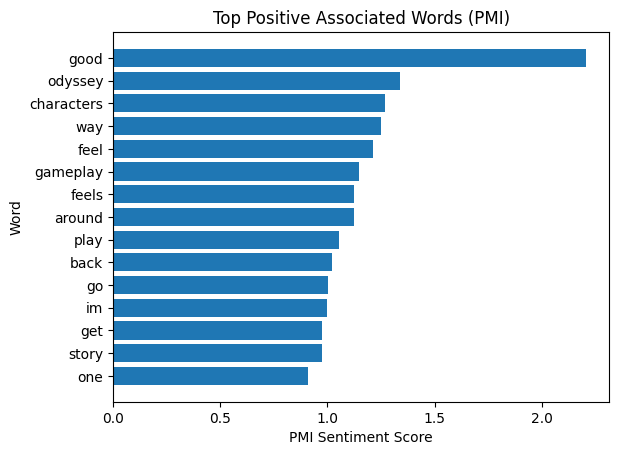

In [73]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(
    top_positive["word"],
    top_positive["sentiment_score"]
)
plt.title("Top Positive Associated Words (PMI)")
plt.xlabel("PMI Sentiment Score")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


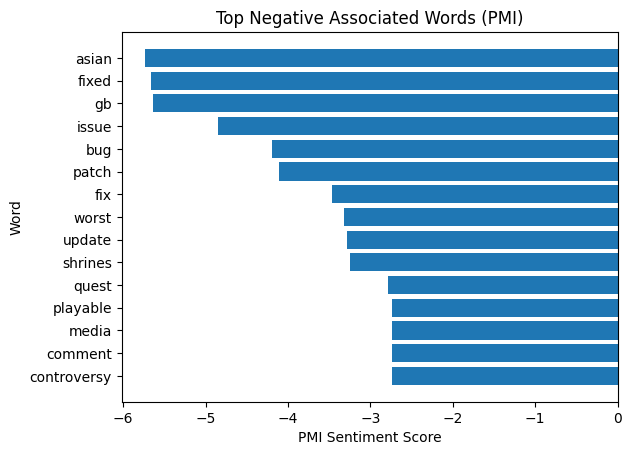

In [74]:
plt.figure()
plt.barh(
    top_negative["word"],
    top_negative["sentiment_score"]
)
plt.title("Top Negative Associated Words (PMI)")
plt.xlabel("PMI Sentiment Score")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


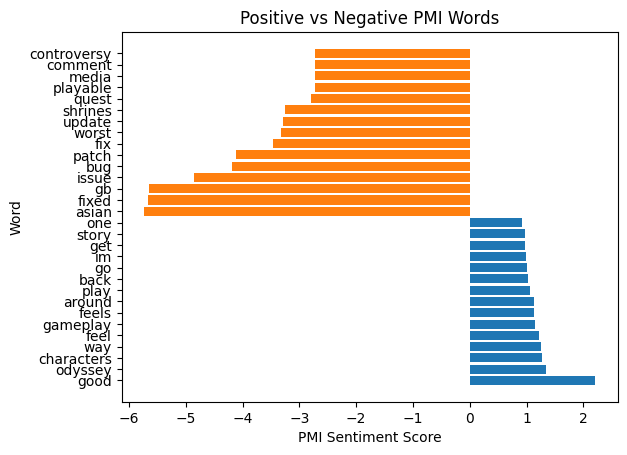

In [75]:
plt.figure()

plt.barh(
    top_positive["word"],
    top_positive["sentiment_score"]
)

plt.barh(
    top_negative["word"],
    top_negative["sentiment_score"]
)

plt.title("Positive vs Negative PMI Words")
plt.xlabel("PMI Sentiment Score")
plt.ylabel("Word")
plt.show()
